In [1]:
import sys
import os
sys.path.append("C:/Users/Hp/Desktop/proyecto")

from src.utils.functions import preparar_datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

Division train, test

In [2]:
ruta = 'C:/Users/Hp/Desktop/ProyectoML_churn/src/data/processed/df_clean.csv'

df_clean = pd.read_csv(ruta) 

In [3]:
df_clean

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Contract Length,Total Spend,Last Interaction,Churn,dataset,Gender_Male,Subscription Type_Premium,Subscription Type_Standard,Contract Length_cod
0,0.255319,39.0,14.0,0.5,0.600000,Annual,0.924444,0.551724,1.0,train,False,False,True,1
1,1.000000,49.0,1.0,1.0,0.266667,Monthly,0.507778,0.172414,1.0,train,False,False,False,0
2,0.787234,14.0,4.0,0.6,0.600000,Quarterly,0.094444,0.068966,1.0,train,False,False,False,1
3,0.851064,38.0,21.0,0.7,0.233333,Monthly,0.328889,0.965517,1.0,train,True,False,True,0
4,0.106383,32.0,20.0,0.5,0.266667,Monthly,0.574444,0.655172,1.0,train,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505201,0.574468,33.0,12.0,0.6,0.700000,Quarterly,0.941111,0.448276,1.0,test,False,False,False,1
505202,0.404255,6.0,1.0,0.5,0.733333,Annual,0.914444,0.275862,1.0,test,True,False,True,1
505203,0.148936,39.0,14.0,0.8,1.000000,Monthly,0.252222,0.655172,1.0,test,True,True,False,0
505204,0.680851,18.0,19.0,0.7,0.733333,Monthly,0.488889,0.413793,1.0,test,False,False,True,0


In [4]:
X_train, y_train, X_test, y_test = preparar_datos(df_clean)

In [5]:
y_train.value_counts()

Churn
1.0    249999
0.0    190833
Name: count, dtype: int64

In [6]:
# Oversampler para equiparar las clases

oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)

X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

df_resampled = pd.concat([X_resampled, y_resampled], axis=1)


In [7]:
# redefino X_y_train

X_train = X_resampled
y_train = y_resampled

In [8]:
# Modelos de clasificación
modelos = [

    ("Random Forest", RandomForestClassifier()),
    ("Logistic Regression",LogisticRegression()),
    ("Decision Tree Classifier",DecisionTreeClassifier()),
    ("Gradient Boosting Classifier",GradientBoostingClassifier()),
    ("KNeighbors Classifier",KNeighborsClassifier()),
    ("GaussianNB",GaussianNB()),

]

In [9]:
resultados = []

for modelo_nombre, modelo in modelos:

    # Entrenamos
    modelo.fit(X_train, y_train)

    # predicciones
    y_pred = modelo.predict(X_test)

    # Calcula las métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Almacena los resultados
    resultados.append({
        "Model": modelo_nombre,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    })

# Convertir los resultados en un DF
resultados_df = pd.DataFrame(resultados)    


In [10]:
resultados_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.505763,0.489366,0.998327,0.656785
1,Logistic Regression,0.580327,0.530675,0.986325,0.690070
2,Decision Tree Classifier,0.505033,0.488997,0.998393,0.656467
3,Gradient Boosting Classifier,0.506152,0.489563,0.998327,0.656963
4,KNeighbors Classifier,0.520443,0.496904,0.994917,0.662785
5,GaussianNB,0.611877,0.571812,0.719149,0.637073


Hiperparametros

In [11]:
# hiperparámetros para RandomForest
parametros_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

rf = RandomForestClassifier(random_state=42)

grid_rf = RandomizedSearchCV(rf, parametros_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_train)

mejor_parametro_rf = grid_rf.best_params_

print(mejor_parametro_rf)

rf_mejor = RandomForestClassifier(random_state=42, **mejor_parametro_rf)
rf_mejor.fit(X_train, y_train)

y_pred_rf_mejor = rf_mejor.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf_mejor)
rep_clasificacion = classification_report(y_test, y_pred_rf_mejor)

print(f'Precisión: {accuracy}')
print(rep_clasificacion)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 100, 'min_samples_split': 8, 'max_features': 2, 'max_depth': 90}
Precisión: 0.5057631963214962
              precision    recall  f1-score   support

         0.0       0.98      0.06      0.12     33881
         1.0       0.49      1.00      0.66     30493

    accuracy                           0.51     64374
   macro avg       0.73      0.53      0.39     64374
weighted avg       0.75      0.51      0.37     64374



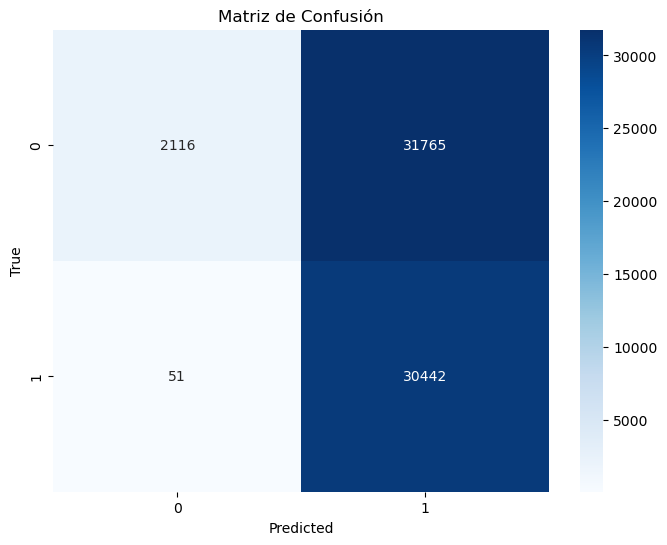

In [12]:
# matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf_mejor)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

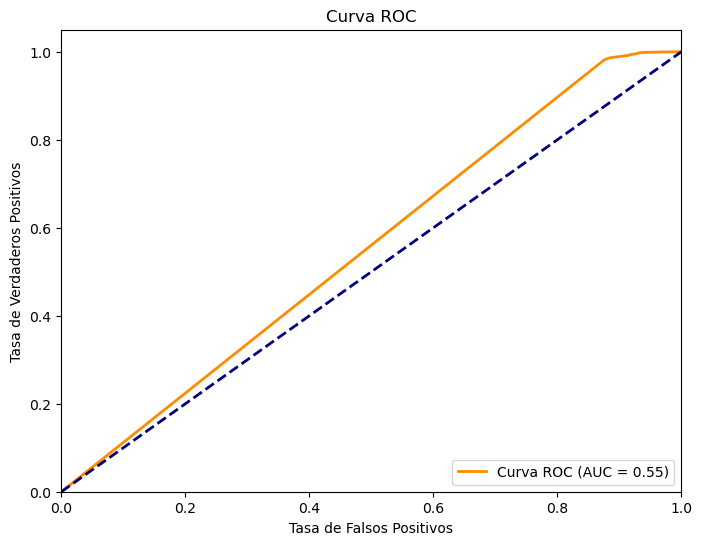

In [13]:
# Calcular las probabilidades de predicción
y_prob = rf_mejor.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


In [14]:
# hiperparametros para DecisionTreeClassifier
parametros_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }

# https://www.kaggle.com/code/fermatsavant/decision-tree-high-acc-using-gridsearchcv

dt = DecisionTreeClassifier(random_state=42)

grid_dt = RandomizedSearchCV(dt, parametros_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)

mejor_parametro_dt = grid_dt.best_params_

print(mejor_parametro_dt)

dt_mejor = DecisionTreeClassifier(random_state=42, **mejor_parametro_dt)
dt_mejor.fit(X_train, y_train)

y_pred_dt_mejor = dt_mejor.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_dt_mejor)
rep_clasificacion = classification_report(y_test, y_pred_dt_mejor)

print(f'Precisión: {accuracy}')
print(rep_clasificacion)


c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_const

{'max_features': 'log2', 'max_depth': 8, 'criterion': 'entropy', 'ccp_alpha': 0.001}
Precisión: 0.5182061080560475
              precision    recall  f1-score   support

         0.0       0.91      0.09      0.17     33881
         1.0       0.50      0.99      0.66     30493

    accuracy                           0.52     64374
   macro avg       0.70      0.54      0.42     64374
weighted avg       0.71      0.52      0.40     64374



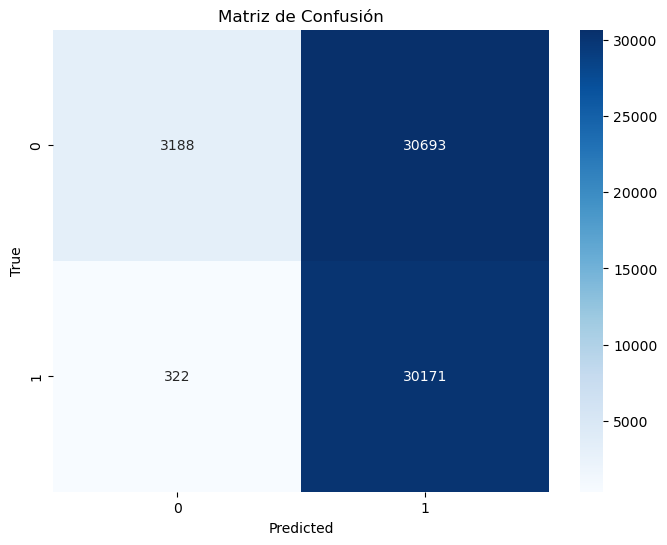

In [15]:
# matriz de confusión
cm = confusion_matrix(y_test, y_pred_dt_mejor)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

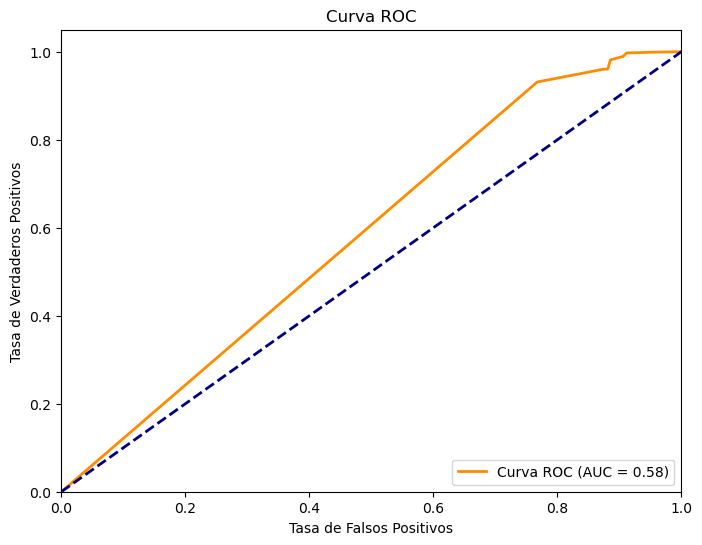

In [16]:
# Calcular las probabilidades de predicción
y_prob = dt_mejor.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


In [17]:
# hiperparametros para Regresión Logística
parametros_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

# https://www.youtube.com/watch?v=pooXM9mM7FU

lr = LogisticRegression(random_state=42)

grid_lr = RandomizedSearchCV(lr, parametros_grid, cv=5, scoring="accuracy" , n_jobs=-1)
grid_lr.fit(X_train, y_train)

mejor_paramametro_lr = grid_lr.best_params_

print(mejor_paramametro_lr)

lr_mejor = LogisticRegression(random_state=42, **mejor_paramametro_lr)
lr_mejor.fit(X_train, y_train)

y_pred_lr_mejor = lr_mejor.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_lr_mejor)
rep_clasificacion = classification_report(y_test, y_pred_lr_mejor)

print(f'Precisión: {accuracy}')
print(rep_clasificacion)


c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    

{'solver': 'newton-cg', 'penalty': 'none', 'max_iter': 1000, 'C': 11.288378916846883}


c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Precisión: 0.5802808587317861
              precision    recall  f1-score   support

         0.0       0.95      0.21      0.35     33881
         1.0       0.53      0.99      0.69     30493

    accuracy                           0.58     64374
   macro avg       0.74      0.60      0.52     64374
weighted avg       0.75      0.58      0.51     64374



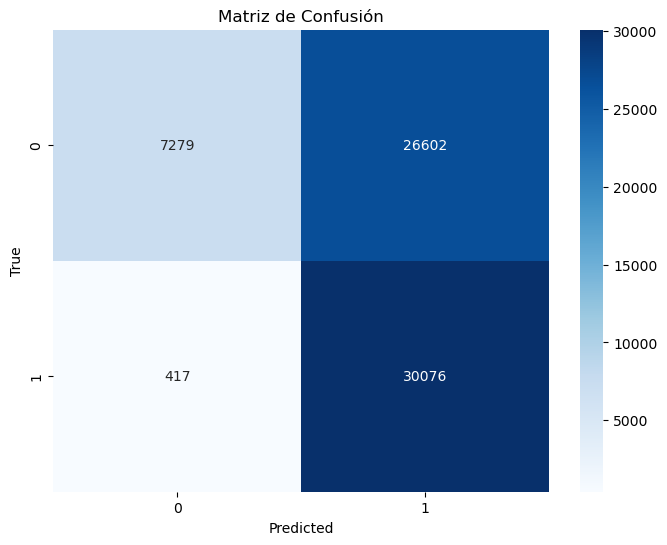

In [18]:
# matriz de confusión
cm = confusion_matrix(y_test, y_pred_lr_mejor)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

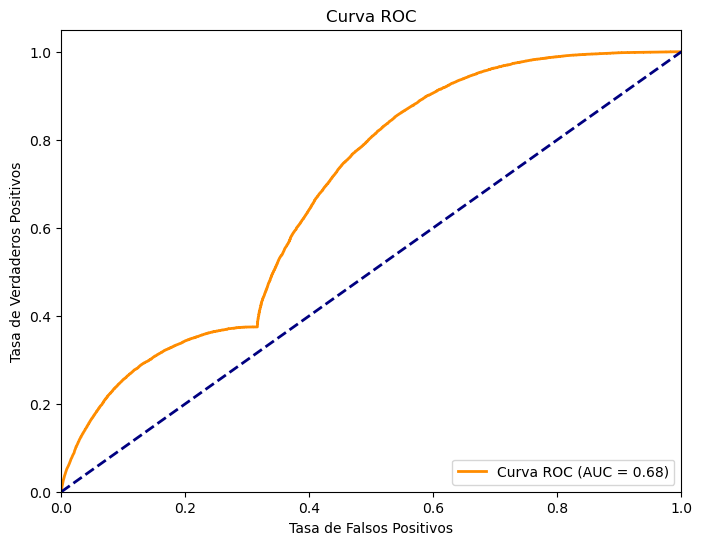

In [19]:

# Calcular las probabilidades de predicción
y_prob = lr_mejor.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


In [20]:
# hiperparametros para KNeighbors Classifier

parametros_grid_knn = {
    'n_neighbors': (1,10, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')
}

# https://www.datasklr.com/select-classification-methods/k-nearest-neighbors

knn = KNeighborsClassifier()

grid_knn = RandomizedSearchCV(knn, parametros_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)

mejor_parametro_knn = grid_knn.best_params_

print(mejor_parametro_knn)

knn_mejor = KNeighborsClassifier(**mejor_parametro_knn)
knn_mejor.fit(X_train, y_train)

y_pred_knn_mejor = knn_mejor.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn_mejor)
rep_clasificacion = classification_report(y_test, y_pred_knn_mejor)

print(f'Precisión: {accuracy}')
print(rep_clasificacion)


{'weights': 'uniform', 'p': 1, 'n_neighbors': 1, 'metric': 'chebyshev', 'leaf_size': 20}
Precisión: 0.5136856494858173
              precision    recall  f1-score   support

         0.0       0.96      0.08      0.15     33881
         1.0       0.49      1.00      0.66     30493

    accuracy                           0.51     64374
   macro avg       0.73      0.54      0.40     64374
weighted avg       0.74      0.51      0.39     64374



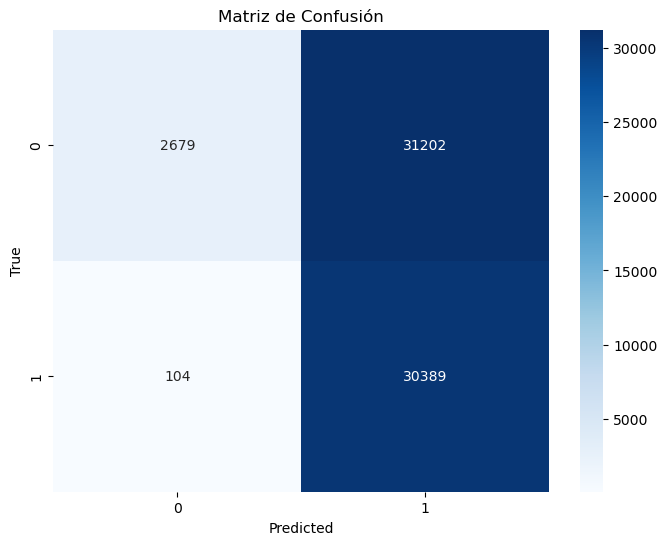

In [21]:
# matriz de confusión
cm = confusion_matrix(y_test, y_pred_knn_mejor)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

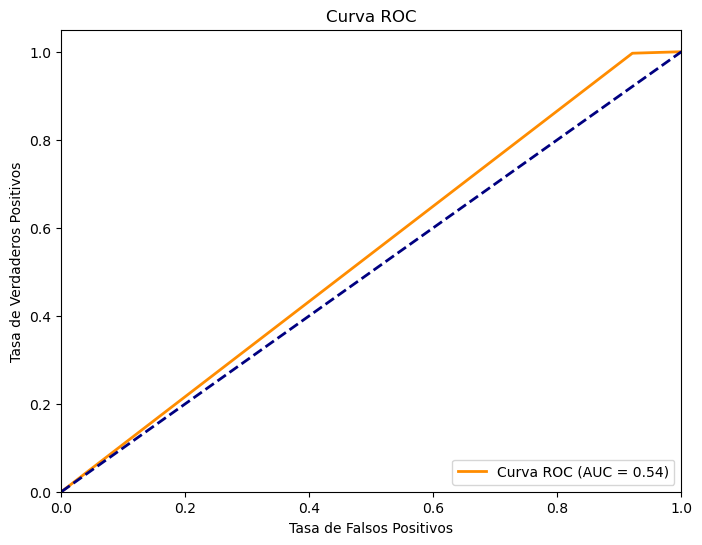

In [22]:
# Calcular las probabilidades de predicción
y_prob = knn_mejor.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


In [23]:
# hiperparámetros para Gradient Boosting
parametros_grid_gb = {
               "criterion": ["friedman_mse",  "mae"],
              "loss":["deviance","exponential"],
              "max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,1,0.5],
              'max_depth': [3,4,5],
              'min_samples_leaf': [4,5,6],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20],

              }

# https://stackoverflow.com/questions/58781601/parameter-tuning-using-gridsearchcv-for-gradientboosting-classifier-in-python

gb = GradientBoostingClassifier(random_state=42)

grid_gb = RandomizedSearchCV(gb, parametros_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train, y_train)

mejor_parametro_gb = grid_gb.best_params_

print(mejor_parametro_gb)

gb_mejor = GradientBoostingClassifier(random_state=42, **mejor_parametro_gb)
gb_mejor.fit(X_train, y_train)

y_pred_gb_mejor = gb_mejor.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gb_mejor)
rep_clasificacion = classification_report(y_test, y_pred_gb_mejor)

print(f'Precisión: {accuracy}')
print(rep_clasificacion)


c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Hp\miniconda3\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_cons

{'subsample': 0.6, 'n_estimators': 15, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 4, 'loss': 'exponential', 'learning_rate': 0.5, 'criterion': 'friedman_mse'}
Precisión: 0.5140118681455246
              precision    recall  f1-score   support

         0.0       0.97      0.08      0.15     33881
         1.0       0.49      1.00      0.66     30493

    accuracy                           0.51     64374
   macro avg       0.73      0.54      0.40     64374
weighted avg       0.74      0.51      0.39     64374



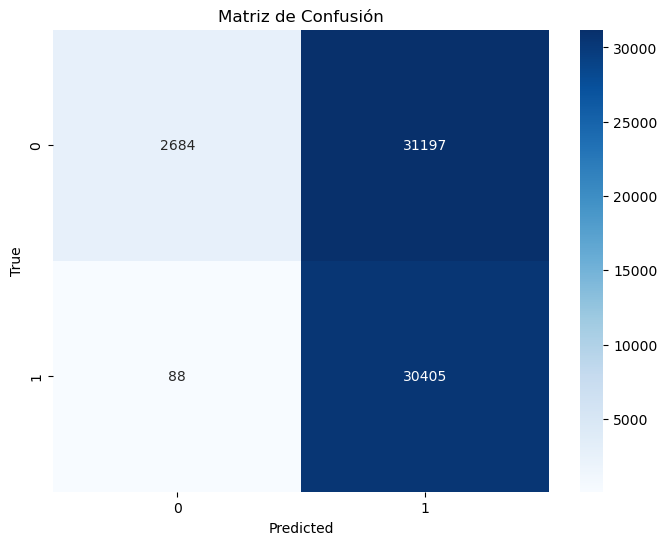

In [24]:
# matriz de confusión
cm = confusion_matrix(y_test, y_pred_gb_mejor)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

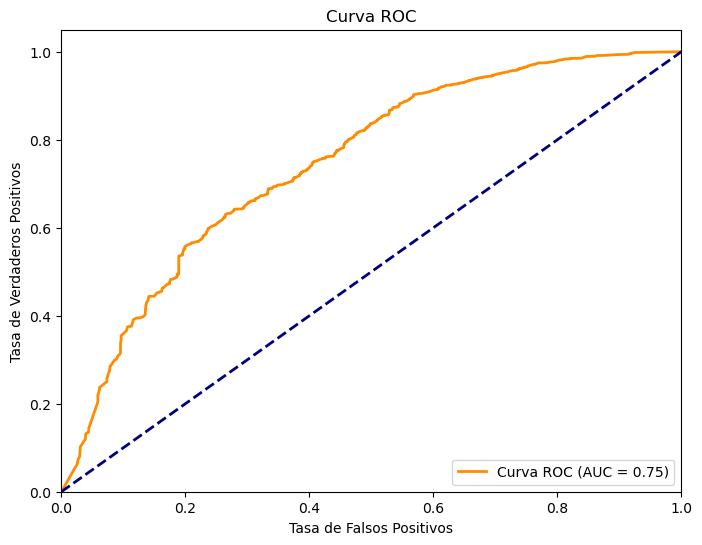

In [25]:

# Calcular las probabilidades de predicción
y_prob = gb_mejor.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


Análisis mejor modelo (Regresión Logística)


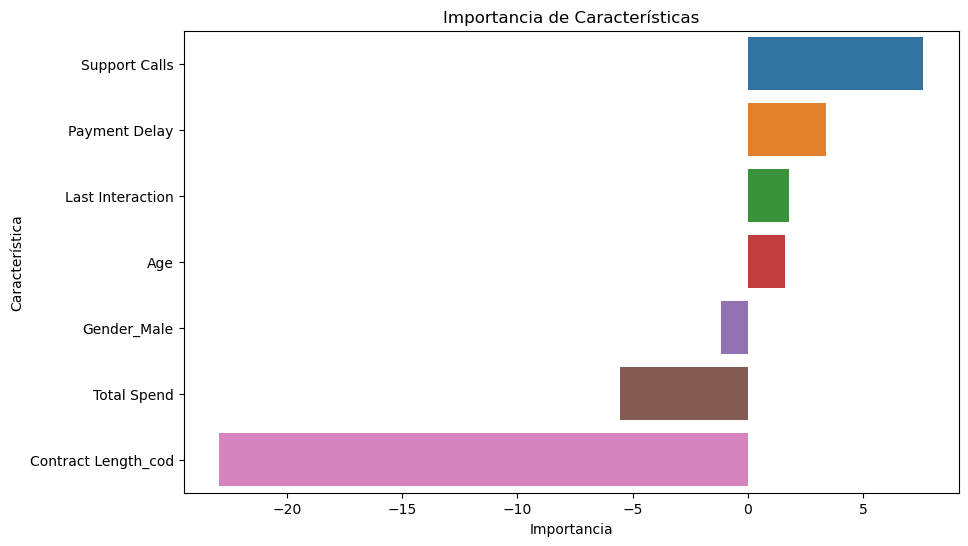

In [26]:
# Obtener la importancia de las características del modelo
importances = lr_mejor.coef_[0]

variables_features = ['Age', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Gender_Male', 'Contract Length_cod']


# Crear un DataFrame con las características y sus importancias
feature_importances = pd.DataFrame({'Feature': variables_features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Graficar las importancias
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Importancia de Características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

In [27]:
# Crear un DataFrame con las etiquetas reales y las predicciones del modelo
resultados = pd.DataFrame({'Verdadero': y_test, 'Predicción': y_pred_lr_mejor})

# Agregar las columnas de características al DataFrame resultados
resultados[['Age', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Gender_Male', 'Contract Length_cod']] = X_test

# Encontrar las instancias en las que el modelo cometió errores
errores_df = resultados[resultados['Verdadero'] != resultados['Predicción']]


In [28]:
errores_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Verdadero,27019.0,0.015434,0.123272,0.0,0.000000,0.000000,0.000000,1.0
Predicción,27019.0,0.984566,0.123272,0.0,1.000000,1.000000,1.000000,1.0
Age,27019.0,0.504276,0.291608,0.0,0.255319,0.510638,0.744681,1.0
Support Calls,27019.0,0.519893,0.307255,0.0,0.300000,0.500000,0.800000,1.0
Payment Delay,27019.0,0.423360,0.276114,0.0,0.200000,0.400000,0.633333,1.0
Total Spend,27019.0,0.466120,0.284218,0.0,0.217778,0.454444,0.702222,1.0
Last Interaction,27019.0,0.516404,0.296735,0.0,0.275862,0.517241,0.758621,1.0
Contract Length_cod,27019.0,0.603649,0.489148,0.0,0.000000,1.000000,1.000000,1.0


In [29]:
import pickle

# Tu modelo
modelo_lr_mejor = lr_mejor

# Ruta al archivo donde deseas guardar el modelo .pkl
ruta_archivo_pkl_lr = "C:/Users/Hp/Desktop/proyecto/src/models/modelo_lr_mejor.pkl"

# Guarda el modelo en el archivo .pkl
with open(ruta_archivo_pkl_lr, 'wb') as archivo_pkl:
    pickle.dump(modelo_lr_mejor, archivo_pkl)